In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function
from scipy.misc import imread, imsave
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
from IPython.display import Image
from skimage import measure

sys.path.append('..')
from deepcalcium.datasets.nf import nf_load_hdf5
from deepcalcium.utils.visuals import mask_outlines
print('Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [9]:
# How many frames, neurons in the neurofinder dataset.
datasets = nf_load_hdf5('all_train')
nb_frames = sum([ds.get('series/raw').shape[0] for ds in datasets])
nb_neurons = sum([ds.get('masks/raw').shape[0] for ds in datasets])
print('Training: %d frames, %d neurons.' % (nb_frames, nb_neurons))
for ds in datasets:
    ds.close()

Training: 66017 frames, 6974 neurons.


In [10]:
# Quantify class-imbalance in neurofinder training datasets.
datasets = nf_load_hdf5('all_train')
mean_pos = 0.
for ds in datasets:
    max_summ = ds.get('masks/max')
    pos_prop = (np.sum(max_summ) * 1. / max_summ.size)
    print(ds.attrs['name'], pos_prop)
    mean_pos += pos_prop / len(datasets)
    ds.close()
print('Mean positive', mean_pos)

neurofinder.00.00 0.0851936340332
neurofinder.00.01 0.0831298828125
neurofinder.00.02 0.0911674499512
neurofinder.00.03 0.0880432128906
neurofinder.00.04 0.113830566406
neurofinder.00.05 0.124702453613
neurofinder.00.06 0.109355926514
neurofinder.00.07 0.0940322875977
neurofinder.00.08 0.119537353516
neurofinder.00.09 0.120193481445
neurofinder.00.10 0.107780456543
neurofinder.00.11 0.0894889831543
neurofinder.01.00 0.261455535889
neurofinder.01.01 0.237033843994
neurofinder.02.00 0.0690879821777
neurofinder.02.01 0.0570983886719
neurofinder.03.00 0.331231046636
neurofinder.04.00 0.0646018981934
neurofinder.04.01 0.146629333496
Mean positive 0.125978616712


HNCcorr \cite{spaen2017hnccorr} + conv2d \cite{conv2d} & 0.602 & 0.702 & 0.617 \\ \hline
Sourcery \footnote{https://github.com/marius10p/suite2p-for-neurofinder} & 0.629 & 0.599 & 0.583 \\ \hline
Suite2p \cite{pachitariu2016suite2p} + Donuts \cite{pachitariu2013extracting} & 0.568 & 0.578 & 0.550 \\ \hline
UNet2DS & 0.578 & 0.584 & 0.536 \\ \hline
HNCcorr \cite{spaen2017hnccorr} & 0.479 & 0.618 & 0.492 \\ \hline


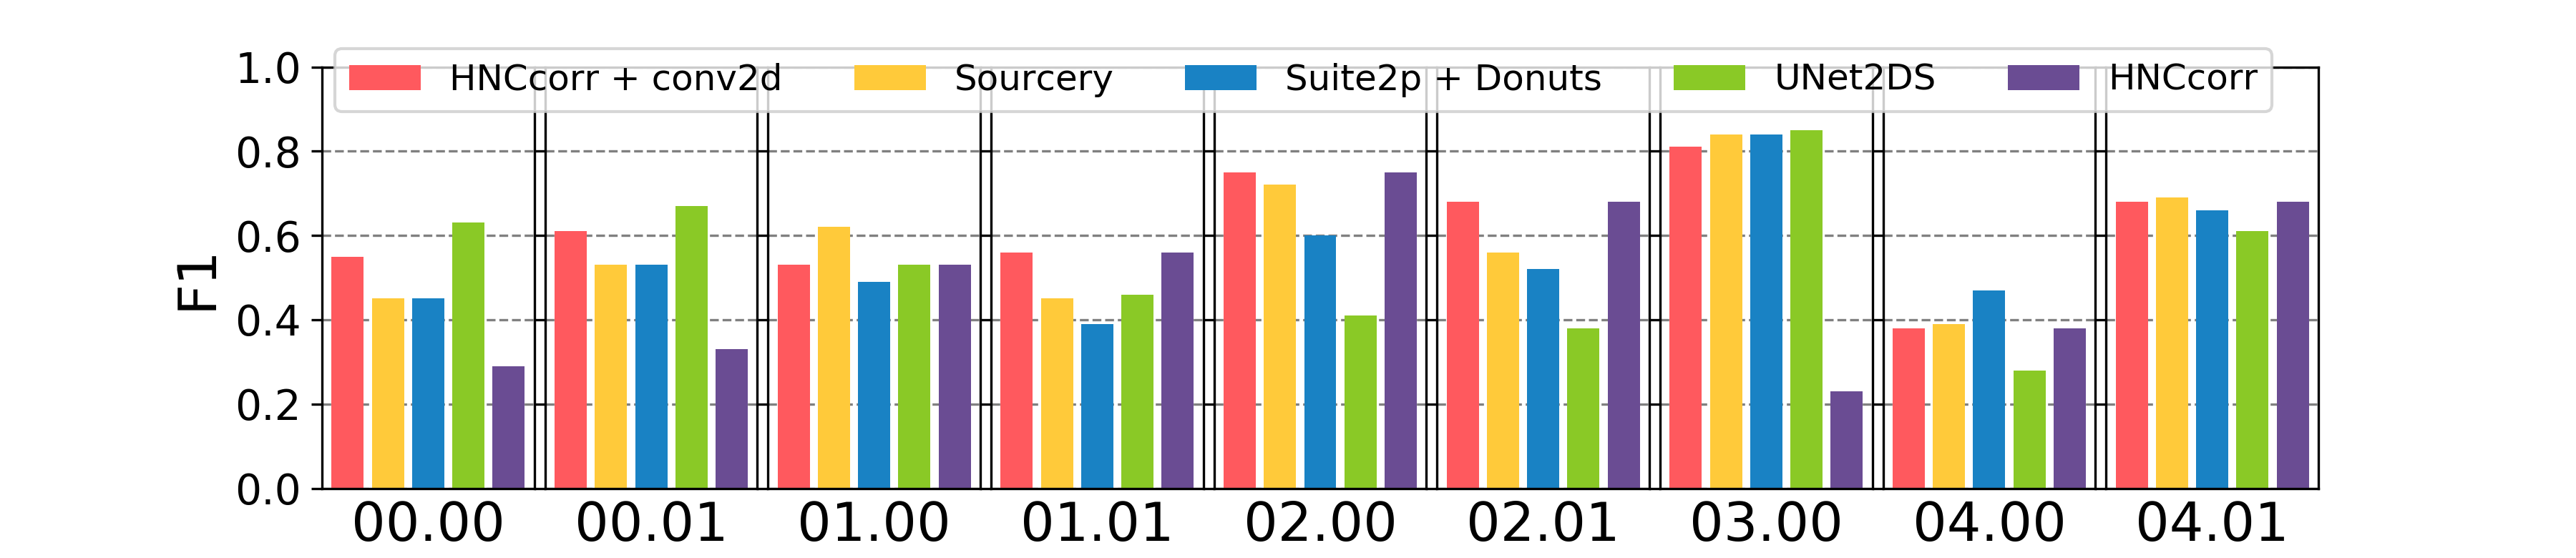

In [75]:
# Table: Neurofinder results. Each set of lists is the combined score, recall scores, and precision scores.
dsids = ['00.00', '00.01', '01.00', '01.01', '02.00', '02.01', '03.00', '04.00', '04.01']
results = [
('HNCcorr \cite{spaen2017hnccorr} + conv2d \cite{conv2d}',
 'HNCcorr + conv2d', [
  [0.55, 0.61, 0.53, 0.56, 0.75, 0.68, 0.81, 0.38, 0.68],
  [0.43, 0.51, 0.39, 0.42, 0.94, 0.89, 0.76, 0.50, 0.58],
  [0.75, 0.76, 0.80, 0.84, 0.62, 0.55, 0.86, 0.31, 0.83]
]),
('Sourcery \\footnote{https://github.com/marius10p/suite2p-for-neurofinder}',
 'Sourcery', [
  [0.45, 0.53, 0.62, 0.45, 0.72, 0.56, 0.84, 0.39, 0.69],
  [0.37, 0.44, 0.52, 0.68, 0.85, 0.81, 0.85, 0.57, 0.57],
  [0.58, 0.67, 0.77, 0.34, 0.62, 0.43, 0.83, 0.29, 0.86]
]),
('Suite2p \cite{pachitariu2016suite2p} + Donuts \cite{pachitariu2013extracting}', 
 'Suite2p + Donuts', [
  [0.45, 0.53, 0.49, 0.39, 0.60, 0.52, 0.84, 0.47, 0.66],
  [0.37, 0.44, 0.39, 0.38, 0.83, 0.72, 0.85, 0.55, 0.58],
  [0.58, 0.67, 0.68, 0.40, 0.47, 0.40, 0.83, 0.41, 0.76]
]),
('UNet2DS', 'UNet2DS', [
  [0.63, 0.67, 0.53, 0.46, 0.41, 0.38, 0.85, 0.28, 0.61],
  [0.52, 0.60, 0.42, 0.38, 0.78, 0.70, 0.80, 0.47, 0.53],
  [0.79, 0.76, 0.74, 0.60, 0.28, 0.26, 0.91, 0.20, 0.72]
]),
('HNCcorr \cite{spaen2017hnccorr}', 'HNCcorr', [
  [0.29, 0.33, 0.53, 0.56, 0.75, 0.68, 0.23, 0.38, 0.68],
  [0.19, 0.25, 0.39, 0.42, 0.94, 0.89, 0.15, 0.50, 0.58],
  [0.62, 0.52, 0.80, 0.84, 0.62, 0.55, 0.47, 0.31, 0.83]
])
]

# Latex results table rows.
for name, shortname, metrics in results:
    print('%s & %.3lf & %.3lf & %.3lf \\\\ \hline' % (name, np.mean(metrics[1]), np.mean(metrics[2]), np.mean(metrics[0])))
    
# Bar plots showing F1 metrics for each dataset.
# https://coolors.co/export/png/ff595e-ffca3a-8ac926-1982c4-6a4c93
colors = ['#FF595E', '#FFCA3A', '#1982C4', '#8AC926', '#6A4C93']
fig, _ = plt.subplots(1, 9, figsize=(12, 2.6))

for idx, ax in enumerate(fig.axes):
    if idx > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('F1', size=18)
        ax.tick_params(axis='y', labelsize=14)
    
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_xlabel(dsids[idx], size=18)
    
    bar = ax.bar(list(range(5)), [m[0][idx] for n,sn,m in results], color=colors)
    ax.set_ylim(0,1)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
# Find a good legend location using manual gradient descent.
fig.legend(bar, [sn for n,sn,m in results], ncol=5, loc=(0.13,0.8), prop={'size':12})
    
plt.subplots_adjust(left=None, wspace=0.05, hspace=0, right=None)
# plt.tight_layout()
plt.savefig('dlmia_fig_nf_results.eps', mode='eps', dpi=300)
plt.savefig('dlmia_fig_nf_results.png', dpi=300)
plt.close()
Image('dlmia_fig_nf_results.png')

neurofinder.00.00 (512, 512)
neurofinder.01.00 (512, 512)
neurofinder.03.00 (498, 490)
neurofinder.04.00 (512, 512)


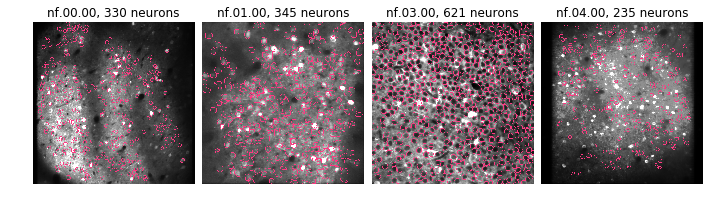

In [72]:
# Figure: mean summaries of training sequences with outlined neurons using the mask_outlines function.
names = ['neurofinder.00.00', 'neurofinder.01.00', 'neurofinder.03.00', 'neurofinder.04.00']
fig, _ = plt.subplots(1, 4, figsize=(12,4))
for name, ax in zip(names, fig.axes):
    ds = nf_load_hdf5(name)[0]
    print(name, ds.get('series/mean').shape)
    outlined = mask_outlines(ds.get('series/mean')[...], 
                             ds.get('masks/raw')[...],
                             [(141,32,72)] * ds.get('masks/raw').shape[0])
    
    outlined = outlined[:min(outlined.shape[:2]),:min(outlined.shape[:2])]
    ax.axis('off')
    ax.imshow(outlined)
    ax.set_title('%s, %d neurons' % (name.replace('neurofinder', 'nf'), ds.get('masks/raw').shape[0]))
    ds.close()
    
plt.subplots_adjust(left=None, wspace=0.05, hspace=0, right=None)
plt.savefig('dlmia_fig_nf_train_outlined.png', dpi=300)
plt.savefig('dlmia_fig_nf_train_outlined.eps', mode='eps', dpi=300)

neurofinder.00.00.test
neurofinder.01.00.test
neurofinder.03.00.test
neurofinder.04.00.test
sj.010517
sj.010617
sj.111216


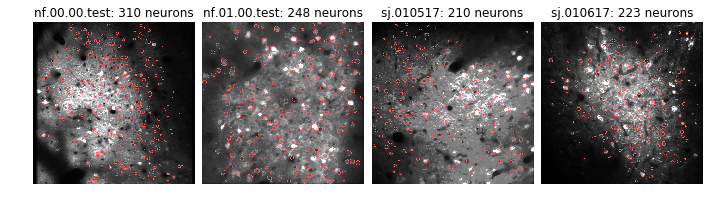

In [71]:
# Figure: predictions on Neurofinder test set and St. Jude datasets.
import h5py
from os import remove, environ
environ['CUDA_VISIBLE_DEVICES'] = "1"
from deepcalcium.models.neurons.unet_2d_summary import UNet2DSummary

fig_data = [] # (name, number of neurons, outlined image)

# Neurofinder predictions taken from submission file.
submission = json.load(open('../checkpoints/unet_2d_summary_128x128_nf_0.53556/submission_latest.json', 'r'))
names = ['neurofinder.00.00.test', 'neurofinder.01.00.test', 'neurofinder.03.00.test', 'neurofinder.04.00.test']

for name, ax in zip(names, fig.axes):
    print(name)
    ds = nf_load_hdf5(name)[0]
    regions = [x['regions'] for x in submission if x['dataset'] in name][0]
    m = np.zeros((len(regions),) + ds.get('series/mean').shape, dtype=np.uint8)
    for i, r in enumerate(regions):
        yy = [y for y,x in r['coordinates']]
        xx = [x for y,x in r['coordinates']]
        m[i][yy, xx] = 1
    outlined = mask_outlines(ds.get('series/mean')[...], m,
                             [(255,89,94)] * m.shape[0])
    outlined = outlined[:min(outlined.shape[:2]),:min(outlined.shape[:2])]
    fig_data.append((name.replace('neurofinder', 'nf'), m.shape[0], outlined))
    ds.close()

# St. Jude predictions made on datasets.
dsfiles = ['../data/sj.010517/dataset.hdf5', '../data/sj.010617/dataset.hdf5', '../data/sj.111216/dataset.hdf5']
datasets = [h5py.File(dsf, 'r') for dsf in dsfiles]
model = UNet2DSummary(cpdir='/home/kzh/tmp')
wpath = '../checkpoints/unet_2d_summary_128x128_nf_0.53556/weights_val_nf_f1_mean.hdf5'
Mp = model.predict(datasets, weights_path=wpath, save=False)

for ds, mp in zip(datasets, Mp):
    name = ds.attrs['name']
    print(name)
    s = ds.get('series/mean')[...]
    outlined = mask_outlines(s, [mp], [(255,89,94)])
    nb_neurons = np.max(measure.label(mp)) - 1
    fig_data.append((name, nb_neurons, outlined))
    ds.close()

# Create the figure.
show_idxs = [0, 1, 4, 5]
fig, _ = plt.subplots(1, 4, figsize=(12,4))
for ax, idx in zip(fig.axes, show_idxs):
    ax.imshow(fig_data[idx][2])
    ax.axis('off')
    ax.set_title('%s: %d neurons' % (fig_data[idx][0], fig_data[idx][1]))
    
plt.subplots_adjust(left=None, wspace=0.05, hspace=0, right=None)
plt.savefig('dlmia_fig_test_outlined.eps', mode='eps', dpi=300)
plt.savefig('dlmia_fig_test_outlined.png', dpi=300)
plt.show()

In [54]:
# Figure: Training metrics.
history = pd.read_csv('../checkpoints/unet_2d_summary_128x128_nf_0.53556/metrics.csv')
print(history.columns)
# plt.figure(figsize=(8,4.5))
# plt.plot(history['loss'], label='Trn. log. loss')
# plt.plot(history['val_loss'], label='Val. log. loss')
# plt.plot(history['dice_squared'],  label='Trn. dice coef.')
# plt.plot(history['val_dice_squared'], label='Val. dice coef.')
# plt.xlabel('Epoch', size=18)
# plt.tick_params(axis='y', labelsize=16)
# plt.tick_params(axis='x', labelsize=16)
# plt.legend(fontsize=18)
# plt.tight_layout()
# plt.savefig('dlmia_fig_history_training_a.eps', mode='eps', dpi=300)
# plt.show(); plt.close()

# fig, _ = plt.subplots(2, 1, figsize=(5,4))
# fig.axes[0].plot(history['tp'], label='Trn. true neuron prop.')
# fig.axes[0].plot(history['pp'], label='Trn. pred. neuron prop.')
# fig.axes[1].plot(history['val_tp'], label='Val true neuron prop.')
# fig.axes[1].plot(history['val_pp'], label='Val pred. neuron prop.')
# fig.axes[0].get_xaxis().set_visible(False)
# fig.axes[1].set_xlabel('Epoch', size=16)
# for ax in fig.axes:
#     ax.set_ylim(0.,0.2)
#     ax.legend(fontsize=14)
#     ax.tick_params(axis='y', labelsize=14)
#     ax.tick_params(axis='x', labelsize=14)
# plt.tight_layout()
# plt.savefig('dlmia_fig_history_training_b.eps', mode='eps', dpi=300)
# plt.show(); plt.close()

Index([u'epoch', u'dice_squared', u'loss', u'prec', u'reca', u'val_nf_f1_adj',
       u'val_nf_f1_mean', u'val_nf_f1_median', u'val_nf_f1_min',
       u'val_nf_prec', u'val_nf_reca', u'yppos', u'ytpos'],
      dtype='object')


In [50]:
# Labeling confidence for each dataset. Histogram of the output activations for each test dataset.

3000it [00:14, 201.88it/s]


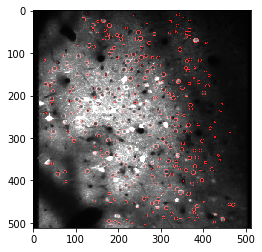

3000it [00:14, 204.07it/s]
3000it [00:15, 199.17it/s]
3000it [00:14, 203.95it/s]
3000it [00:14, 201.24it/s]


4 iterations, 9370 frames / minute


In [53]:
# How fast are predictions? Delete the hdf5 dataset before making predictions.
# 3000 frames in ~110 seconds -> ~1600 frames / minute.
from time import time
from os import remove, environ
environ['CUDA_VISIBLE_DEVICES'] = "1"
from deepcalcium.models.neurons.unet_2d_summary import UNet2DSummary

fpms = []
nb_iters = 5

for i in xrange(nb_iters):
    tic = time()
    remove('/home/kzh/.deep-calcium-datasets/neurofinder.00.00.test/dataset.hdf5')
    ds = nf_load_hdf5('neurofinder.00.00.test')
    model = UNet2DSummary(cpdir='/home/kzh/tmp/')
    wpath = '../checkpoints/unet_2d_summary_128x128_nf_0.53556/weights_val_nf_f1_mean.hdf5'
    Mp = model.predict(ds, weights_path=wpath, save=True)
    nb_frames = ds[0].get('series/raw').shape[0]
    nb_sec = time() - tic
    fpm = int(nb_frames * 1. / (nb_sec / 60))
    fpms.append(fpm)
    if i == 0:
        plt.imshow(imread('/home/kzh/tmp/neurofinder.00.00.test_mp.png'), cmap='gray')
        plt.show()
    
print('%d iterations, %d frames / minute' % (nb_iters, np.mean(fpms)))